In [1]:
"""
Identifying wildfires which burned >=5% total aspen forest cover AND required incident response

Data Sources:
    -FIRED
    -ICS-209-PLUS
    -FPA-FOD

Author: maxwell.cook@colorado.edu
"""

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.spatial import cKDTree
from datetime import timedelta
from shapely.geometry import Point

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
icsdir = os.path.join(maindir, 'ics209-plus-fired/data/')

print("Ready !")

Ready !


In [2]:
# Load some boundary data
states = os.path.join(maindir, 'data/boundaries/political/TIGER/tl19_us_states_w_ak_lambert.gpkg')
states = gpd.read_file(states)
states.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [42]:
# Functions !

def best_match(fired_perim, neighbors, max_date_diff=14, max_size_diff=50):
    fired_perim['ig_date'] = pd.to_datetime(fired_perim['ig_date'])
    ig_date = fired_perim['ig_date']
    perim_size = fired_perim['tot_ar_km2'] * 247.105  # Convert from km^2 to acres

    # Initialize best score and match
    best_score = float('inf')
    best_match = None
    
    for _, point in neighbors.iterrows():
        # Calculate the date difference
        point['DISCOVERY_DATE'] = pd.to_datetime(point['DISCOVERY_DATE'])
        ics_start_date = point['DISCOVERY_DATE']
        date_diff = abs((ig_date - ics_start_date).days)
        
        if date_diff > max_date_diff:
            continue  # Skip if date difference exceeds max_date_diff
    
        # Calculate the size difference
        ics_size = point.get('FINAL_ACRES', np.nan)
        
        if perim_size != 0:
            size_diff = abs((ics_size - perim_size) / perim_size) * 100
        else:
            size_diff = float('inf')  # If perim_size is 0, treat it as infinite difference

        if max_size_diff is not None:
            if size_diff > max_size_diff:
                continue  # Skip if size difference exceeds max_size_diff
        
        # Calculate the spatial distance (assuming it's precomputed)
        spatial_dist = point.get('spatial_dist', 0)
        
        # Composite score (you can adjust the weights as needed)
        score = spatial_dist + date_diff + size_diff
        
        # Check if this is the best match
        if score < best_score:
            best_score = score
            best_match = point
    
    return best_match


def find_nearest(perims, points, NN=10, max_dist=None, date_range=14, max_size_diff=None):
    """ 
    Finds the N nearest points based on spatial proximity and temporal alignment.

    Args:
        - perims: GeoDataFrame of wildfire perimeters
        - points: GeoDataFrame of incident points (ICS-209-PLUS)
        - NN: the number of neighbors to return
        - max_dist: the maximum distance to search for nearest points
        - date_range: range of days to include in temporal filtering
    Returns: NN nearest points 
    """

    # Ensure the same projection
    points = points.to_crs(perims.crs)

    # Convert date columns to datetime
    perims['ig_date'] = pd.to_datetime(perims['ig_date'])
    points['DISCOVERY_DATE'] = pd.to_datetime(points['DISCOVERY_DATE'])

    out_nns = {}  # storing the resulting nearest neighbors for each perimeter
    for _, perim in perims.iterrows():
        fired_id = perim['fired_id']
        centroid = perim.geometry.centroid  # centroid of the fire perimeter

        # Use the entire geometry instead of just the centroid for spatial matching
        perim_geom = perim.geometry

        # Grab the ignition date information
        ig_date = perim['ig_date']
        
        # Create a date range filter
        date_filter = (points['DISCOVERY_DATE'] >= ig_date - pd.Timedelta(days=date_range)) & \
                      (points['DISCOVERY_DATE'] <= ig_date + pd.Timedelta(days=date_range))
        inci_points = points[date_filter]

        # Check if there are any matches first
        if inci_points.empty:
            print(f"No matching points based on ignition date found for fire {fired_id}")
            out_nns[fired_id] = None
            continue

        # Calculate distances from the fire perimeter to the incident points
        distances = inci_points.geometry.apply(lambda x: perim_geom.distance(x))
        
        # Filter by the maximum distance if provided
        if max_dist is not None:
            inci_points = inci_points[distances <= max_dist]
            distances = distances[distances <= max_dist]

        # Sort by distance and retain the nearest NN points
        nearest_points = inci_points.iloc[distances.argsort()[:NN]].copy() if not inci_points.empty else None

        if nearest_points is not None:
            best_ = best_match(perim, nearest_points, max_size_diff=max_size_diff)
            out_nns[fired_id] = best_
        else:
            print(f"No matching ICS-209-PLUS points for {fired_id}, skipping ...")
            continue
        
    return out_nns


print("Functions ready for use !")

Functions ready for use !


In [4]:
# Load the wildfire dataset
inci_path = os.path.join(icsdir, 'tabular/raw/wf-incidents/ics209-plus_v3.2/ics209-plus-wf_incidents_1999to2023.csv')
incidents = pd.read_csv(inci_path, low_memory=False)
incidents.head()

,Unnamed: 0,INCIDENT_ID,INCIDENT_NUMBER,INCIDENT_NAME,INCTYP_ABBREVIATION,FINAL_ACRES,CAUSE,COMPLEX,DISCOVERY_DATE,DISCOVERY_DOY,...,WF_CESSATION_DATE,WF_CESSATION_DOY,WF_MAX_FSR,WF_MAX_GROWTH_DATE,WF_MAX_GROWTH_DOY,WF_GROWTH_DURATION,SUP_SERIES,SUP_METHOD_INITIAL,SUP_METHOD_FINAL,SUP_PERCENT_FS
0,0,1999_AK-AIC-B251_MINTO,AK-AIC-B251,MINTO,WF,3800.0,H,True,1999-06-14 00:00:00,165.0,...,1999-06-17 00:00:00,168.0,1500.0,1999-06-14 00:00:00,165.0,3.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,0.0
1,1,1999_AK-ARM-B222_DONNELLY FLATS,AK-ARM-B222,DONNELLY FLATS,WF,18000.0,H,True,1999-06-11 00:00:00,162.0,...,1999-06-18 00:00:00,169.0,7820.0,1999-06-15 00:00:00,166.0,7.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,0.0
2,2,1999_AK-GAD-B447_ROUNDABOUT MOUNTAIN,AK-GAD-B447,ROUNDABOUT MOUNTAIN,WF,6600.0,L,True,1999-07-11 00:00:00,192.0,...,1999-07-16 00:00:00,197.0,2270.0,1999-07-16 00:00:00,197.0,5.0,"[nan, nan, nan, nan, nan, nan, nan]",NaN,NaN,0.0
3,3,1999_AK-STA-901106_HELMAUR (CLARK WOLVERINE),AK-STA-901106,HELMAUR (CLARK WOLVERINE),WF,221.0,H,True,1999-05-18 00:00:00,138.0,...,1999-05-20 00:00:00,140.0,110.5,1999-05-20 00:00:00,140.0,2.0,[nan],NaN,NaN,0.0
4,4,1999_AK-STA-901107_EKLUTNA,AK-STA-901107,EKLUTNA,WF,383.0,H,True,1999-05-18 00:00:00,138.0,...,1999-05-23 00:00:00,143.0,225.0,1999-05-19 00:00:00,139.0,5.0,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,0.0


In [5]:
incidents['DISCOVERY_DATE'] = pd.to_datetime(incidents['DISCOVERY_DATE'])
incidents = incidents.dropna(subset=['DISCOVERY_DATE'])
incidents['START_YEAR'] = incidents['DISCOVERY_DATE'].dt.year
incidents['START_YEAR'] = incidents['START_YEAR'].astype(int)

print(incidents['START_YEAR'].head())

0    1999
1    1999
2    1999
3    1999
4    1999
Name: START_YEAR, dtype: int64


In [6]:
incidents.columns

Index(['Unnamed: 0', 'INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FATALITIES_RESPONDER', 'FATALITIES_PUBLIC',
       'FINAL_REPORT_DATE', 'INCIDENT_ID_OLD', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'STR_THREATENED_MAX',
       'STR_THREATENED_COMM_MAX', 'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM',
       'TOTAL_PERSON

In [7]:
# Create a spatial points data
geometry = [Point(xy) for xy in zip(incidents['POO_LONGITUDE'], incidents['POO_LATITUDE'])]
# Create a GeoDataFrame
incidents_gdf = gpd.GeoDataFrame(incidents, geometry=geometry)
# Set the coordinate reference system (CRS)
incidents_gdf = incidents_gdf.set_crs(epsg=4326, inplace=True)

In [8]:
len(incidents_gdf)

39150

In [9]:
# Intersect with state boundaries and match with POO_STATE
incidents_gdf = gpd.sjoin(incidents_gdf, states[['geometry', 'STUSPS']].to_crs(4326), how='inner', predicate='intersects')
incidents_gdf = incidents_gdf[incidents_gdf['POO_STATE'] == incidents_gdf['STUSPS']] # filter where states match

In [10]:
len(incidents_gdf)

36597

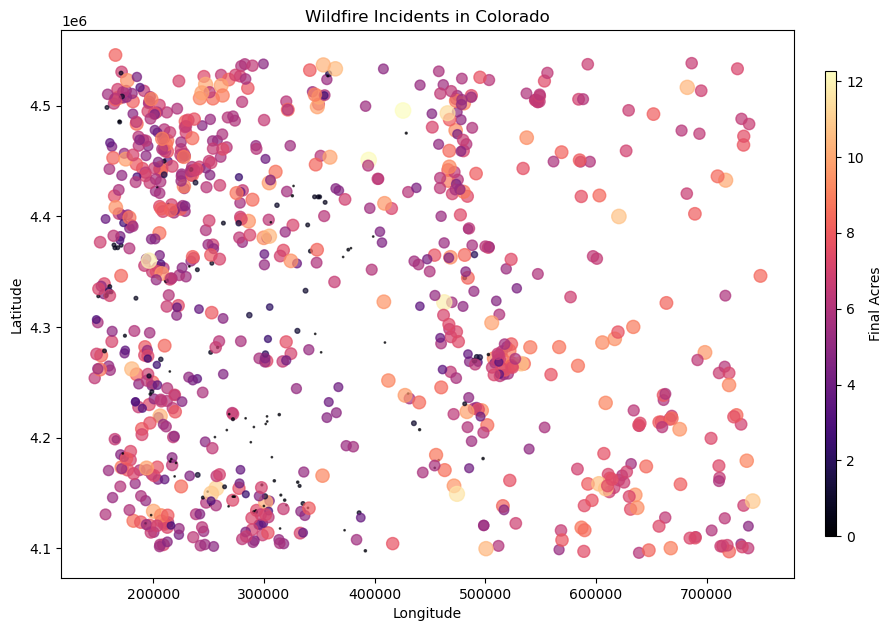

In [11]:
# Filter the GeoDataFrame for points in Colorado
gdf_colorado = incidents_gdf[incidents_gdf['POO_STATE'] == 'CO'].to_crs(32613)
gdf_colorado['log_FINAL_ACRS'] = np.log1p(gdf_colorado['FINAL_ACRES'])  # log1p to handle log(0) issues

# Plot the points on a map, with size based on FINAL_ACRES
fig, ax = plt.subplots(figsize=(10, 10))

# Normalize the FINAL_ACRES values for color mapping
norm = colors.Normalize(vmin=gdf_colorado['log_FINAL_ACRS'].min(), vmax=gdf_colorado['log_FINAL_ACRS'].max())

# Plot the points with size and color based on FINAL_ACRES
gdf_colorado.plot(ax=ax, marker='o',
                  markersize=gdf_colorado['log_FINAL_ACRS'] * 10,  # Adjust the scaling factor as needed
                  color=gdf_colorado['log_FINAL_ACRS'].apply(lambda x: cm.magma(norm(x))),
                  alpha=0.7)

# Set title and labels
plt.title('Wildfire Incidents in Colorado')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.015, pad=0.04, aspect=40)
cbar.set_label('Final Acres')

# Display the plot
plt.show()

del gdf_colorado

In [12]:
# save the ICS-209-PLUS spatial points
out_dir = os.path.join(maindir, 'ics209-plus-fired/data/spatial/raw/wf-incidents/ics209-plus_v3.2/')
out_file = os.path.join(out_dir, 'ics209plus-wf_incidents_spatial_us_ak_1999to2023.gpkg')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
# Set thew projection and export
incidents_gdf = incidents_gdf.to_crs(5070)
incidents_gdf.to_file(out_file)
print(f"file exported to {out_file}")

file exported to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/ics209-plus-fired/data/spatial/raw/wf-incidents/ics209-plus_v3.2/ics209plus-wf_incidents_spatial_us_ak_1999to2023.gpkg


In [13]:
# Load the FIRED perimeters
fires_path = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west_aspen.gpkg')
fired = gpd.read_file(fires_path)
fired.head()

,fired_id,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,tot_pix,tot_ar_km2,fsr_px_dy,...,lc_mode,lc_name,lc_desc,lc_type,eco_mode,eco_name,eco_type,tot_perim,pct_aspen,geometry
0,3518,2021-08-27 00:00:00,239,8,2021,2021-09-02 00:00:00,7,8,1.717269,1.142857,...,10,Grasslands,Dominated by herbaceous annuals (<2m),IGBP global vegetation classification scheme,30.0,Wasatch and Uinta montane forests,WWF Terrestrial Ecoregions of the World,7422.750866,7.299270,"MULTIPOLYGON (((-1525864.633 1728392.374, -152..."
1,4014,2019-07-28 00:00:00,209,7,2019,2019-08-19 00:00:00,23,113,24.256430,4.913043,...,10,Grasslands,Dominated by herbaceous annuals (<2m),IGBP global vegetation classification scheme,3.0,Arizona Mountains forests,WWF Terrestrial Ecoregions of the World,68586.001732,7.249325,"MULTIPOLYGON (((-1438398.214 1617352.125, -143..."
2,4131,2023-10-06 00:00:00,279,10,2023,2023-10-06 00:00:00,1,1,0.214659,1.000000,...,10,Grasslands,Dominated by herbaceous annuals (<2m),IGBP global vegetation classification scheme,3.0,Arizona Mountains forests,WWF Terrestrial Ecoregions of the World,1861.250866,35.564854,"MULTIPOLYGON (((-1436631.660 1612308.040, -143..."
3,4225,2018-08-01 00:00:00,213,8,2018,2018-08-18 00:00:00,18,34,7.298395,1.888889,...,10,Grasslands,Dominated by herbaceous annuals (<2m),IGBP global vegetation classification scheme,3.0,Arizona Mountains forests,WWF Terrestrial Ecoregions of the World,16688.250866,11.038641,"MULTIPOLYGON (((-1419991.902 1598087.710, -142..."
4,5006,2022-06-08 00:00:00,159,6,2022,2022-06-18 00:00:00,11,565,121.282150,51.363636,...,10,Grasslands,Dominated by herbaceous annuals (<2m),IGBP global vegetation classification scheme,3.0,Arizona Mountains forests,WWF Terrestrial Ecoregions of the World,142723.252598,5.197895,"MULTIPOLYGON (((-1405958.646 1476506.575, -140..."


In [14]:
len(fired)

102

In [15]:
print(incidents_gdf.crs)
print(fired.crs)

EPSG:5070
EPSG:5070


In [16]:
ics209s = incidents_gdf.to_crs(fired.crs)

In [17]:
ics209s = ics209s[ics209s['START_YEAR'] >= 2018]
print(ics209s['START_YEAR'].min())
print(ics209s['START_YEAR'].max())

2018
2023


In [43]:
# Identify matching fired perimiters and ics-209 incident reports
ics_fired_nn = find_nearest(fired, ics209s, NN=5, max_dist=5000, date_range=14, max_size_diff=None)
print(f'Found {len(ics_fired_nn)} matches; {len(ics_fired_nn)/len(fired)*100} %')

No matching ICS-209-PLUS points for 4014, skipping ...
No matching ICS-209-PLUS points for 4131, skipping ...
No matching ICS-209-PLUS points for 6466, skipping ...
No matching ICS-209-PLUS points for 42699, skipping ...
No matching ICS-209-PLUS points for 42749, skipping ...
No matching ICS-209-PLUS points for 43509, skipping ...
No matching ICS-209-PLUS points for 43577, skipping ...
No matching ICS-209-PLUS points for 43630, skipping ...
No matching ICS-209-PLUS points for 43686, skipping ...
No matching ICS-209-PLUS points for 43692, skipping ...
No matching ICS-209-PLUS points for 43696, skipping ...
No matching ICS-209-PLUS points for 43728, skipping ...
No matching ICS-209-PLUS points for 43794, skipping ...
No matching ICS-209-PLUS points for 43858, skipping ...
No matching ICS-209-PLUS points for 44668, skipping ...
No matching ICS-209-PLUS points for 44927, skipping ...
No matching ICS-209-PLUS points for 44962, skipping ...
No matching ICS-209-PLUS points for 44969, skipping

In [39]:
ics_fired_nn['189859'][['INCIDENT_ID','INCIDENT_NAME','FINAL_ACRES','STUSPS']].head()

INCIDENT_ID      2020_11917747_MULLEN
INCIDENT_NAME                  MULLEN
FINAL_ACRES                  176878.0
STUSPS                             WY
Name: 34407, dtype: object

In [ ]:
# Filter the matches to identify the best match

In [ ]:
best_ics_matches = best_match(